In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

#to data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#NLP tools
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv
/kaggle/input/cyber-bullying/final_data.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv('../input/cyber-bullying/final_data.csv')
dataset.head()

,Unnamed: 0,class,tweet
0,0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64652 entries, 0 to 64651
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  64652 non-null  int64 
 1   class       64652 non-null  int64 
 2   tweet       64652 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,64652.0,32325.50000,18663.569139,0.0,16162.75,32325.5,48488.25,64651.0
class,64652.0,0.81272,0.390139,0.0,1.00,1.0,1.00,1.0


In [5]:
print(dataset.isnull().sum() * 100 /len(dataset))

Unnamed: 0    0.0
class         0.0
tweet         0.0
dtype: float64


In [6]:
# Adding text-length as a field in the dataset
dataset['text_length'] = dataset['tweet'].apply(len)
dataset.head()

,Unnamed: 0,class,tweet,text_length
0,0,0,!!! RT @mayasolovely: As a woman you shouldn't...,140
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137


<AxesSubplot:xlabel='class', ylabel='count'>

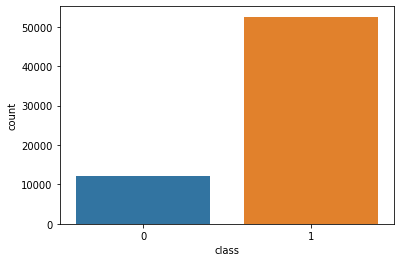

In [7]:
import seaborn as sns
sns.countplot('class',data=dataset)

### Class 0 indicates hate speech

### Class 1 indicates Offensive language

### Class 2 indicates neither 

In [8]:
dataset['class'].unique()

array([0, 1])

<AxesSubplot:xlabel='class', ylabel='count'>

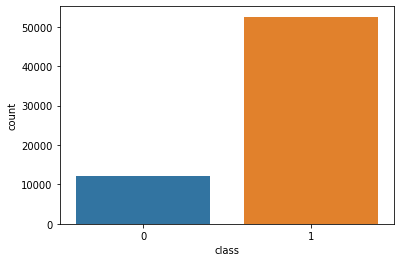

In [9]:
sns.countplot('class',data=dataset)

### Class 0 indicates tweets which are non-offensive
### Class 1 indicates tweets which are offensive

In [10]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

In [11]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Stemming
## 4. Stopwords removal

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

In [12]:
processed_tweets = preprocess(tweet)
dataset['processed_tweets'] = processed_tweets
dataset[["tweet","processed_tweets"]].head()

,tweet,processed_tweets
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous amp man alway take t...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


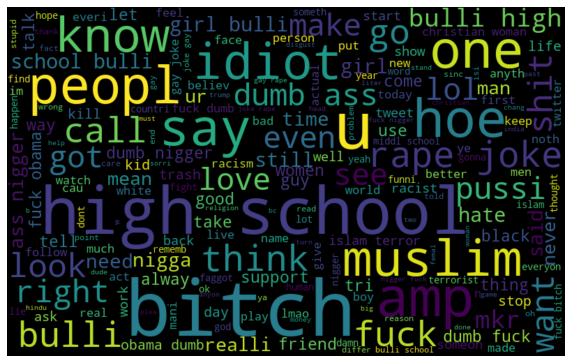

In [13]:
from wordcloud import WordCloud
# visualizing which of the word is most commonly used in the twitter dataset
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Offensive words 

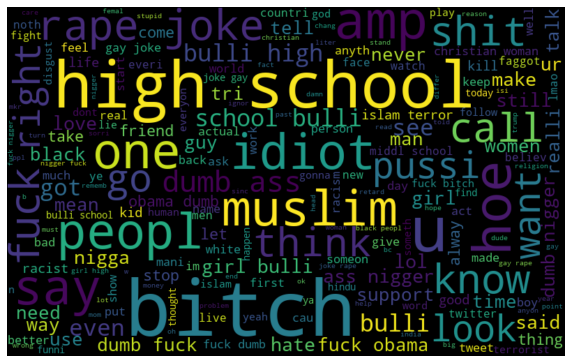

In [14]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Non-Offensive words 

In [15]:
dataset[dataset['class']==0]

,Unnamed: 0,class,tweet,text_length,processed_tweets
0,0,0,!!! RT @mayasolovely: As a woman you shouldn't...,140,woman complain clean hous amp man alway take t...
40,40,0,""" momma said no pussy cats inside my doghouse """,47,momma said pussi cat insid doghous
63,63,0,"""@Addicted2Guys: -SimplyAddictedToGuys http://...",87,simplyaddictedtoguy woof woof hot scalli lad
66,66,0,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",66,woof woof hot sole
67,67,0,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...",69,lemmi eat oreo amp dish one oreo lol
...,...,...,...,...,...
32723,32723,0,I don't know what I want to wear#ugh,36,know want wear ugh
32724,32724,0,Argh another round of instant restaurants....o...,61,argh anoth round instant restaur mkr
32725,32725,0,Teacher sets up new charity to tackle anti-gay...,76,teacher set new chariti tackl anti gay bulli
32726,32726,0,"I can barely tolerate Kat and Andre, Katie and...",113,bare toler kat andr kati nikki annoy rather se...


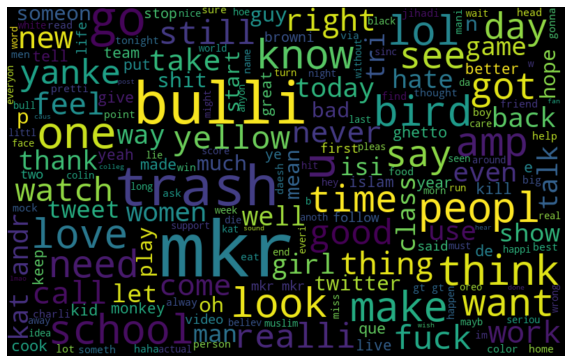

In [16]:
# visualizing which of the word is most commonly used for offensive speech
nonoffensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(nonoffensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [17]:
def wordListToFreqDict(wordlist):
    wordfreq = [(wordlist.count(p))/len(wordlist) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [18]:
offensive_words = offensive_words.split()
nonoffensive_words = nonoffensive_words.split()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tf idf
tfidf_vector = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
# TF-IDF feature matrix
tfidf = tfidf_vector.fit_transform(dataset["processed_tweets"])
tfidf = tfidf_vector.transform(dataset["processed_tweets"])
tfidf

<64652x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 767732 stored elements in Compressed Sparse Row format>

In [20]:
tfidf.shape

(64652, 10000)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2400
           1       0.95      0.97      0.96     10531

    accuracy                           0.93     12931
   macro avg       0.89      0.87      0.88     12931
weighted avg       0.93      0.93      0.93     12931

Logistic Regression, Accuracy Score: 0.9307864820972855


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
X = tfidf
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test
clf = MLPClassifier(hidden_layer_sizes=(6,5),random_state=5,verbose=True,learning_rate_init=0.01)
clf.fit(X_train,y_train)
ypred=clf.predict(X_test)
accuracy_score(y_test,ypred)

Iteration 1, loss = 0.24959056
Iteration 2, loss = 0.12736037
Iteration 3, loss = 0.09558221
Iteration 4, loss = 0.07287212
Iteration 5, loss = 0.05613174
Iteration 6, loss = 0.04416659
Iteration 7, loss = 0.03483330
Iteration 8, loss = 0.02956236
Iteration 9, loss = 0.02585748
Iteration 10, loss = 0.02371085
Iteration 11, loss = 0.02387371
Iteration 12, loss = 0.02381827
Iteration 13, loss = 0.02351282
Iteration 14, loss = 0.02298838
Iteration 15, loss = 0.02360292
Iteration 16, loss = 0.02268835
Iteration 17, loss = 0.02128460
Iteration 18, loss = 0.02081391
Iteration 19, loss = 0.01999196
Iteration 20, loss = 0.01884732
Iteration 21, loss = 0.01947377
Iteration 22, loss = 0.01897335
Iteration 23, loss = 0.01891709
Iteration 24, loss = 0.01903749
Iteration 25, loss = 0.02123679
Iteration 26, loss = 0.02138317
Iteration 27, loss = 0.01904548
Iteration 28, loss = 0.01880138
Iteration 29, loss = 0.01717962
Iteration 30, loss = 0.01699677
Iteration 31, loss = 0.01756627
Iteration 32, los

0.9150340276345639

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [24]:
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier(max_depth=1000, min_samples_split=5, n_estimators=500,random_state=0)
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      2400
           1       0.96      0.97      0.96     10531

    accuracy                           0.94     12931
   macro avg       0.90      0.89      0.89     12931
weighted avg       0.94      0.94      0.94     12931

Random Forest, Accuracy Score: 0.9367411646431058


In [25]:
support =LinearSVC()
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2400
           1       0.96      0.96      0.96     10531

    accuracy                           0.93     12931
   macro avg       0.89      0.89      0.89     12931
weighted avg       0.93      0.93      0.93     12931

SVM, Accuracy Score: 0.9336478230608615


In [26]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import pandas as pd
param_grid= {'kernel': ('linear', 'rbf'),
              'C': [1, 10, 100]}
base_estimator = SVC(gamma='scale')
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,factor=2, min_resources=20).fit(X_train_tfidf,y_train)

In [29]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import pandas as pd
param_grid= {'kernel': ('linear', 'rbf'),
              'C': [1, 10, 100]}
base_estimator = SVC(gamma='scale')
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, min_resources=20).fit(X_train_tfidf,y_train)

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train_tfidf, y_train, cv=5)
clf.fit(X_train_tfidf, y_train)
clf.score(X_train_tfidf, y_train)

0.9327352526053247

In [ ]:
# Training classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
clf1 = AdaBoostClassifier(n_estimators=100)
clf2 = RandomForestClassifier(random_state=0)
clf3= MLPClassifier(hidden_layer_sizes=(6,5),random_state=5,verbose=True,learning_rate_init=0.01)
eclf = VotingClassifier(estimators=[('ada', clf1), ('rf', clf2),('mlp',clf3)],voting='soft', weights=[2, 3, 10])
clf1 = clf1.fit(X_train_tfidf, y_train)
clf2 = clf2.fit(X_train_tfidf, y_train)
clf3 = clf3.fit(X_train_tfidf, y_train)
eclf = eclf.fit(X_train_tfidf, y_train)

In [ ]:
y_preds = eclf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Accuracy Score:",acc1)